In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

import pickle

In [2]:
from sklearn.decomposition import PCA

In [3]:
RANDOM_SEED = 99
np.random.seed(RANDOM_SEED)

# Carregando os dados

In [4]:
df_list = []
for file in os.listdir('MachineLearningCVE/'):
  df_aux = pd.read_csv(f'MachineLearningCVE/{file}')
  df_list.append(df_aux)
df = pd.concat(df_list, ignore_index=True)

df.head()
df['label'].value_counts()

,count
label,
fuzzy,21464
Benign,9035
spoofing,8508
stealth,5000
dos,689
impersonation,490
freestate,170


In [5]:
df.head()

,timestamp,interface,can_id,data,label
0,2025-08-08 16:32:30,can0,0x3f,A2 30 B0 45 89 2A 5C 44,fuzzy
1,2025-08-08 16:32:30,can0,0xb,E9 98 2B 5D 45 BA 0A 03,fuzzy
2,2025-08-08 16:32:30,can0,0x65e,6E 04 0D 02 03 1A 4D 70,fuzzy
3,2025-08-08 16:32:30,can0,0x6d8,DD B1 28 87 B6 FD 76 84,fuzzy
4,2025-08-08 16:32:30,can0,0x7b3,82 17 08 33 02 65 4A 93,fuzzy


Algumas colunas tem seus nomes iniciados com espaços ou finalizados com espaços. Vamos remover esses espaços não úteis para ajustar o nome das colunas.

In [6]:
df.columns = df.columns.str.strip()

In [7]:
df.shape

(45356, 5)

In [8]:
df.columns

Index(['timestamp', 'interface', 'can_id', 'data', 'label'], dtype='object')

Registros duplicados

# Dividindo dados nos conjuntos de treino, validação e teste

**Conjunto de treino**

Para a detecção de anomalias, vamos usar somente os dados que representam o tráfego benigno para o conjunto de treino. Dessa forma, os algoritmos serão capazes de identificar padrões e desvios em relação ao comportamento normal (benigno) dos dados.

**Conjuntos de validação e teste**

Porém, devem ser incluídos dados que representam o tráfego maliciosos nos conjuntos de validação e teste. Esses dados maliciosos no conjunto de validação são importantes para que possamos definir um *threshold* para que seja possível detectar anomalias. Além disso, os dados maliciosos também precisam ser incluídos no conjunto de teste para que possamos avaliar o desempenho do nosso modelo.

In [9]:
df_train = df.query('label == "Benign"').sample(frac=0.6, random_state=RANDOM_SEED)
df_val_test = df.drop(df_train.index)

df_train = df_train.reset_index(drop=True)
df_val_test = df_val_test.reset_index(drop=True)

X_train = df_train.drop('label', axis='columns')

In [10]:
X_val, X_test, classes_val, classes_test = train_test_split(df_val_test.drop('label', axis='columns'), df_val_test['label'], test_size=0.65, stratify=df_val_test['label'], random_state=RANDOM_SEED)

X_val, X_test = X_val.reset_index(drop=True), X_test.reset_index(drop=True)
classes_val, classes_test =  classes_val.reset_index(drop=True), classes_test.reset_index(drop=True)

y_val, y_test = classes_val.apply(lambda c: 0 if c == 'Benign' else 1), classes_test.apply(lambda c: 0 if c == 'Benign' else 1)

In [11]:
del df_train, df_val_test

# Convertendo os dados

In [12]:
# Convert 'can_id' from hexadecimal string to integer, then to float
for df in [X_train, X_val, X_test]:
    df['can_id'] = df['can_id'].apply(
        lambda x: int(x, 16) if isinstance(x, str) and x.startswith('0x') else x
    ).astype(float)
    df['can_id'] = df['can_id'].fillna(0)

# Converter timestamp para datetime
for df in [X_train, X_val, X_test]:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Calcular diferença de tempo (ms) por can_id, garantindo ordenação
for df in [X_train, X_val, X_test]:
    df.sort_values(['can_id', 'timestamp'], inplace=True)
    df['timestamp_diff_ms'] = (
        df.groupby('can_id')['timestamp']
          .diff()
          .dt.total_seconds() * 1000
    )
    df['timestamp_diff_ms'] = df['timestamp_diff_ms'].fillna(0)
    df.drop(columns=['timestamp'], inplace=True)  # Remove timestamp
    df.sort_index(inplace=True)  # volta à ordem original, se quiser manter

# One-hot encode 'interface'
X_train = pd.get_dummies(X_train, columns=['interface'], drop_first=True)
X_val = pd.get_dummies(X_val, columns=['interface'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['interface'], drop_first=True)

# Process 'data' column
def process_data_column(df):
    data_split = df['data'].str.split(' ', expand=True)
    for col in data_split.columns:
        data_split[col] = data_split[col].apply(
            lambda x: int(x, 16) if isinstance(x, str) else np.nan
        )
    data_split = data_split.fillna(0)
    data_split.columns = [f'data_{i}' for i in range(data_split.shape[1])]
    return pd.concat([df.drop('data', axis=1), data_split], axis=1)

X_train = process_data_column(X_train)
X_val = process_data_column(X_val)
X_test = process_data_column(X_test)

# Align columns to training set
train_cols = X_train.columns
X_val = X_val.reindex(columns=train_cols, fill_value=0)
X_test = X_test.reindex(columns=train_cols, fill_value=0)


In [14]:
X_train.head()

,can_id,timestamp_diff_ms,data_0,data_1
0,54.0,1000.0,17,17.0
1,305.0,35000.0,1,0.0
2,305.0,1000.0,0,0.0
3,305.0,23000.0,0,0.0
4,305.0,58000.0,0,0.0


In [ ]:
X_val.head()

,can_id,timestamp_diff_ms,data_0,data_1
0,305.0,1000.0,1,0.0
1,647.0,0.0,124,149.0
2,209.0,0.0,80,126.0
3,385.0,1000.0,167,206.0
4,224.0,11000.0,240,165.0


In [ ]:
X_test.head()

,can_id,timestamp_diff_ms,data_0,data_1
0,54.0,1000.0,1,1.0
1,1913.0,3000.0,204,51.0
2,424.0,0.0,228,117.0
3,321.0,1000.0,0,0.0
4,1209.0,4000.0,220,18.0


# Normalizando os dados

É importante normalizar os dados para lidar com diferentes escalas, sensibilidades a escalas e até mesmo melhorar o desempenho da convergência dos algoritmos.

Caso não seja realizada a normalização, um valor de 10000 para uma feature como "Flow Bytes/s" terá impacto similar ao modelo quanto um valor de 10000 para uma feature como "Flow Packets/s". Isso é prejudicial, pois o impacto desse valor para as duas features deve ser tratado de forma distinta, já que as mesmas têm escalas e sensibilidades também distintas.

In [15]:
std_scaler = StandardScaler()
std_scaler = std_scaler.fit(X_train)

norm_X_train = std_scaler.transform(X_train)
norm_X_val = std_scaler.transform(X_val)
norm_X_test = std_scaler.transform(X_test)

with open('std_scaler.p', 'wb') as f:
    pickle.dump(std_scaler, f)

with open('train_cols.p', 'wb') as f:
    pickle.dump(list(X_train.columns), f)

In [16]:
del X_train, X_val, X_test

# Detecção de Anomalias com o KMeans

Dado um grupo de amostras de dados, o objetivo do K-Means é criar k clusters de modo que cada amostra de dados pertença a um dos grupos formados.

O primeiro passo para a construção dos clusters é selecionar aleatoriamente k centróides, que são representações do centro de cada cluster. De maneira mais simples, se cada amostra de dados puder ser representada por um ponto, o centróide de um grupo é um ponto no centro deste grupo.
Em seguida, três outras etapas são repetidas para atualizar os grupos até que os seus centróides tenham estabilizado e não mudem mais de lugar:

1. A distância euclidiana é calculada entre cada centróide e todas as amostras de dados.
2. Cada amostra é atribuída ao centróide mais próximo que forma os grupos;
3. Cada centróide de cluster é atualizado através da média da distância entre as amostras de dados dentro de cada cluster.


Porém, para que o algoritmo KMeans seja utilizado, precisamos informar um número K de clusters esperados. Uma forma de obter um número de clusters que melhor se adapte ao conjunto de dados é através da métrica de **silhouette score**. Essa métrica é calculada considerando as distâncias intra cluster e inter clusters de cada amostra do conjunto de dados.

Para saber mais sobre essa métrica [clique aqui](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c)

In [ ]:
random_train_indexes = np.random.choice(norm_X_train.shape[0], int(norm_X_train.shape[0]*0.5), replace=False) # Increased subset size to 50%
norm_X_train_subset = norm_X_train[random_train_indexes,:]

In [ ]:
print(norm_X_train_subset.shape)

(2710, 4)


In [ ]:
k_list = list(range(2, 21))
silhouette_score_list = []
for k in tqdm(k_list):
    model_kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    model_kmeans = model_kmeans.fit(norm_X_train_subset)
    s_score = silhouette_score(norm_X_train_subset, model_kmeans.predict(norm_X_train_subset))
    silhouette_score_list.append(s_score)

  0%|          | 0/19 [00:00<?, ?it/s]

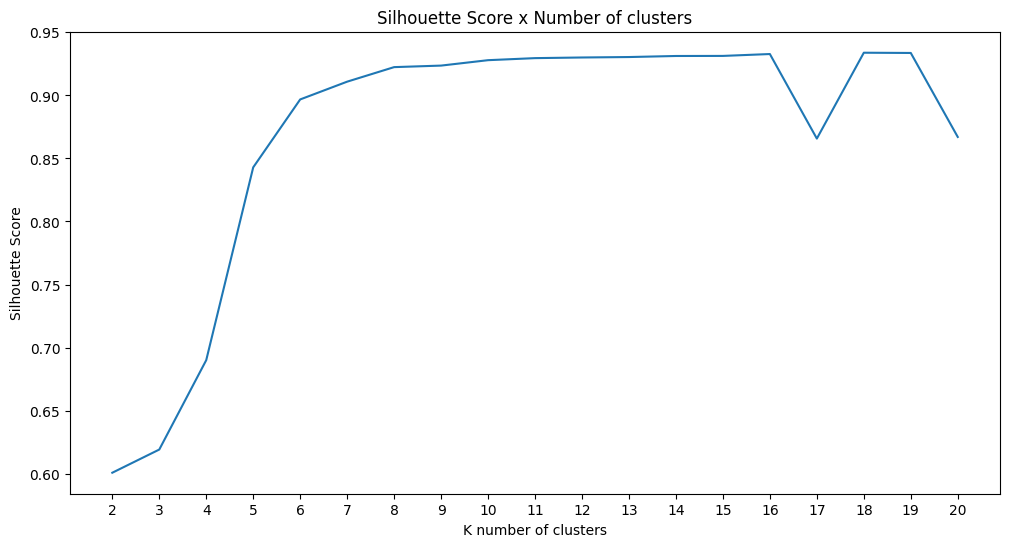

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('K number of clusters')
ax.set_ylabel('Silhouette Score')
ax.set_xticks(k_list)
ax.set_title('Silhouette Score x Number of clusters')
ax.plot(k_list, silhouette_score_list)

  0%|          | 0/4 [00:00<?, ?it/s]

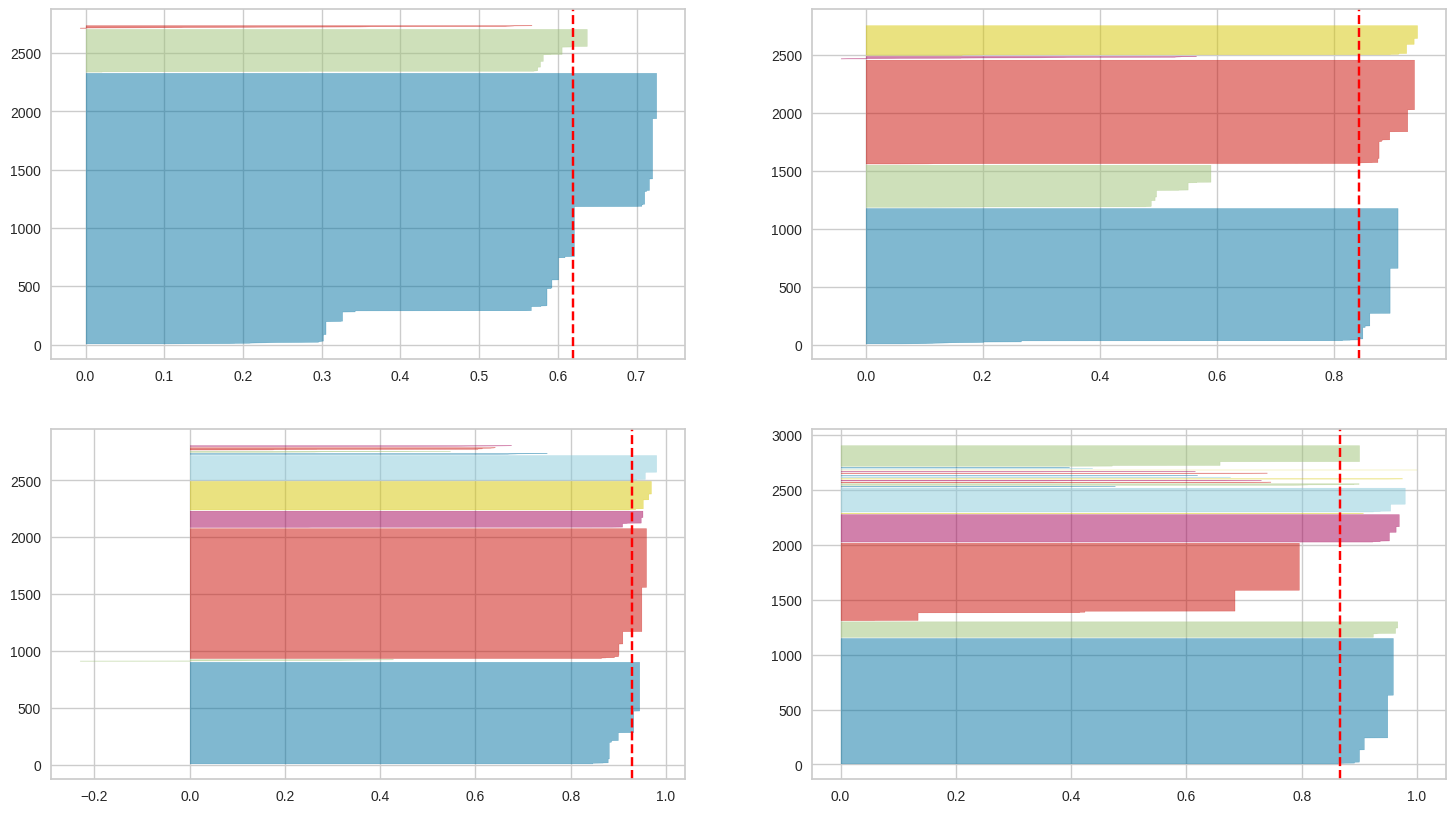

In [ ]:
# Silhouette Visualizer

from yellowbrick.cluster import SilhouetteVisualizer
k_list_for_visualization = [3, 5, 10, 20]

fig, ax = plt.subplots(2, 2, figsize=(18,10))
for i, k in enumerate(tqdm(k_list_for_visualization)):
    '''
    Create KMeans instance for different number of clusters
    '''
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=33)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(norm_X_train_subset)

In [ ]:
K_CLUSTERS = 10

In [ ]:
import pickle

model_kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=RANDOM_SEED, n_init=10)
model_kmeans = model_kmeans.fit(norm_X_train)
# Export the trained KMeans model using pickle
with open('kmeans_model.p', 'wb') as f:
    pickle.dump(model_kmeans, f)

In [ ]:
def plot_pca(X, model_kmeans=None, print_centroids = False):
  pca = PCA(n_components=2, random_state=RANDOM_SEED)
  X_pca = pca.fit_transform(X)

  fig, ax = plt.subplots(figsize=(14, 6))
  ax.set_title('PCA Analysis')

  if print_centroids and model_kmeans is not None:
    cluster_centers_principal_components = pca.transform(model_kmeans.cluster_centers_)
    num_clusters = cluster_centers_principal_components.shape[0]

    X_clusters = model_kmeans.predict(X)

    # For each cluster, plot their respective X data instances
    for cluster in range(num_clusters):
      indexes = np.where(X_clusters == cluster)
      if X_pca[indexes,:].shape[1] == 3:
        print(indexes)
      print(X_pca[indexes,:].shape)
      ax.scatter(X_pca[indexes, 0], X_pca[indexes, 1], s=1, c=plt.cm.tab20(cluster), label=f'Cluster#{cluster}')

    # For each cluster centroid, plot the centroid
    for i, cluster_center_pc in enumerate(cluster_centers_principal_components):
      ax.scatter(cluster_center_pc[0], cluster_center_pc[1], c='black', s=8, marker='x')
      ax.annotate(f'Cluster#{i}', (cluster_center_pc[0], cluster_center_pc[1]), size=10)
    ax.legend()

  else:
    ax.scatter(X_pca[:,0], X_pca[:,1], s=1)

(1, 1767, 2)
(1, 2280, 2)
(1, 482, 2)
(1, 496, 2)
(1, 12, 2)
(1, 20, 2)
(1, 266, 2)
(1, 64, 2)
(1, 12, 2)
(1, 22, 2)


/tmp/ipython-input-415288942.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_pca[indexes, 0], X_pca[indexes, 1], s=1, c=plt.cm.tab20(cluster), label=f'Cluster#{cluster}')


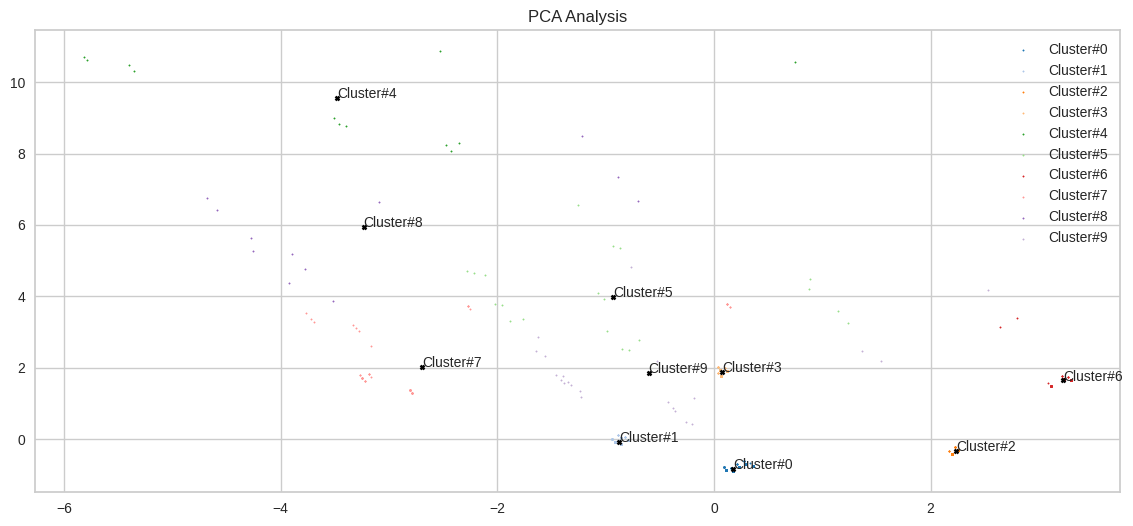

In [ ]:
plot_pca(norm_X_train, model_kmeans, print_centroids=True)

# Definindo um threshold e avaliando resultados

In [21]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [22]:
def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'label':y_labels,'prediction':y_pred})
  total_per_label = aux_df['label'].value_counts().to_dict()
  correct_predictions_per_label = aux_df.query('label != "Benign" and prediction == True').groupby('label').size().to_dict()
  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 'Benign':
      continue
    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr
  return tpr_per_attack

In [23]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [24]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

## Conjunto de validação

In [ ]:
val_centroids_distances = model_kmeans.transform(norm_X_val)
val_anomaly_scores = np.min(val_centroids_distances, axis=1)

In [ ]:
print(val_centroids_distances.shape)

(13977, 10)


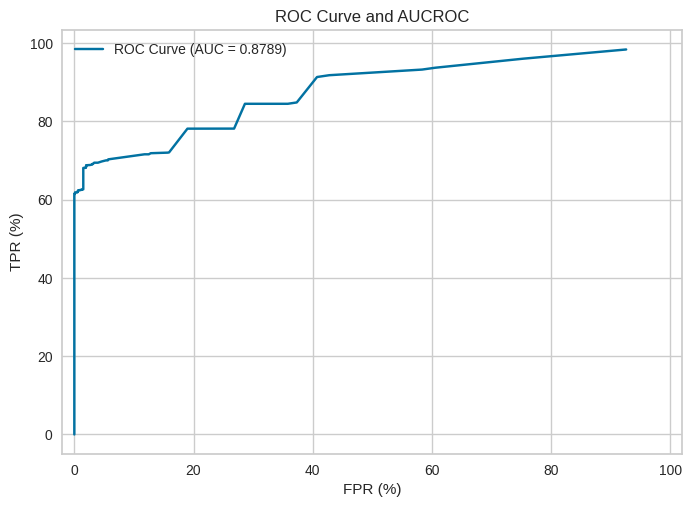

In [ ]:
plot_roc_curve(y_val, val_anomaly_scores)

## Escolha do threshold

Existem muitas formas de se escolher um threshold para a detecção de anomalias, e no geral essa escolha irá depender da tarefa a ser realizada e das caracteristicas do ambiente onde o sistema de detecção será utilizado. Aqui utilizaremos o Youden-index, ou estatística J de Youden. Essa estatistica geralmente é usada para definir o "valor ideal" de theshold pois atinge seu valor máximo com o thresold que gera a menor quantidade de falsos positivos e a maior quantidade de verdadeiros positivos. O ponto maximo do Youden-index pode ser entendido como o valor de threshold que gera o ponto da curva ROC mais distante o possível da diagonal do gráfico ou simplismente o valor da curva roc que maximiza o valor de  $tpr-fpr$.

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, val_anomaly_scores)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr')

,fpr,tpr,thresholds,youden-index
99,0.019763,0.687775,1.158749,0.668012
101,0.020553,0.688169,1.038982,0.667615
103,0.021344,0.688326,0.913122,0.666982
85,0.015020,0.681325,1.662678,0.666305
104,0.022134,0.688326,0.857633,0.666192
87,0.016601,0.681403,1.598299,0.664803
105,0.023715,0.688483,0.813065,0.664768
91,0.018972,0.682898,1.325360,0.663926
107,0.025296,0.688562,0.782722,0.663266
109,0.026087,0.688719,0.745684,0.662632


In [ ]:
max_youden_index = df_val_roc['youden-index'].max()
print(f'O valor máximo do índice de Youden é: {max_youden_index}')

O valor máximo do índice de Youden é: 0.6680124845466734


In [ ]:
BEST_VALIDATION_THRESHOLD = 0.6680124845466734

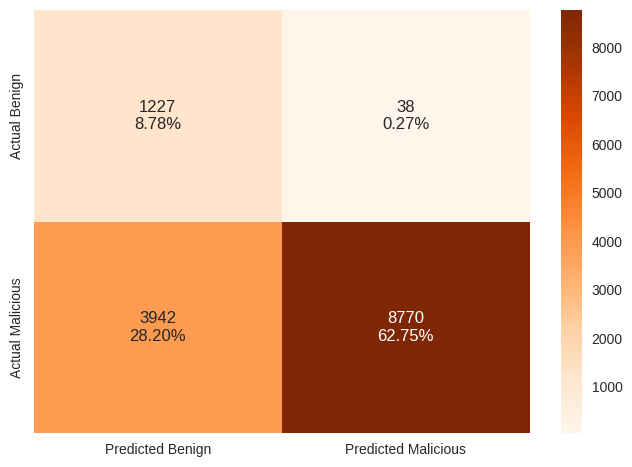

In [ ]:
plot_confusion_matrix(y_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'acc': np.float64(0.7152464763540102),
 'tpr': np.float64(0.6898993077407174),
 'fpr': np.float64(0.030039525691699605),
 'precision': np.float64(0.995685740236149),
 'f1-score': np.float64(0.8150557620817843)}

In [ ]:
get_tpr_per_attack(classes_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'fuzzy': 0.999866879659212,
 'spoofing': 0.24546675621222297,
 'stealth': 0.032,
 'dos': 1.0,
 'impersonation': 1.0,
 'freestate': 1.0}

## Conjunto de teste

In [ ]:
test_centroids_distances = model_kmeans.transform(norm_X_test)
test_anomaly_scores = np.min(test_centroids_distances, axis=1)

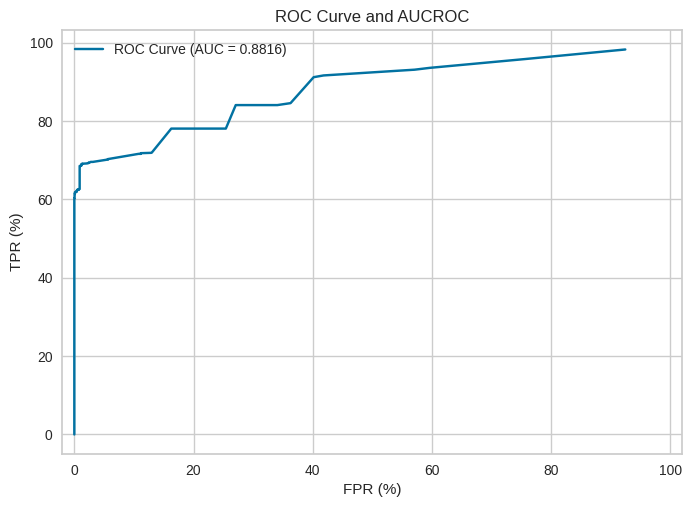

In [ ]:
plot_roc_curve(y_test, test_anomaly_scores)

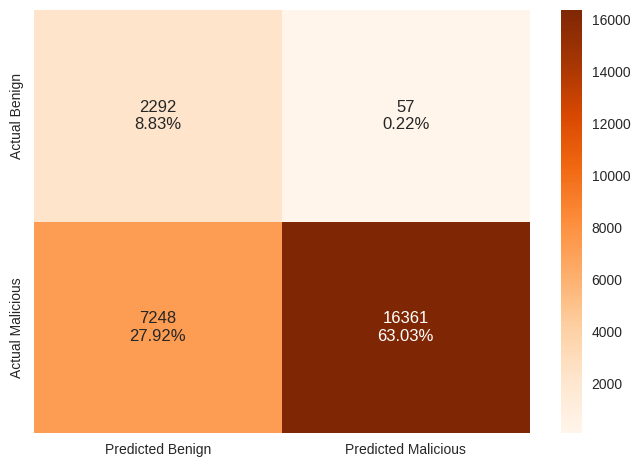

In [ ]:
plot_confusion_matrix(y_test, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_test, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'acc': np.float64(0.7185838662454734),
 'tpr': np.float64(0.6929984328010504),
 'fpr': np.float64(0.024265644955300127),
 'precision': np.float64(0.9965282007552686),
 'f1-score': np.float64(0.8174981887226123)}

In [ ]:
get_tpr_per_attack(classes_test, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'fuzzy': 1.0,
 'spoofing': 0.26383363471971066,
 'stealth': 0.02246153846153846,
 'dos': 1.0,
 'impersonation': 1.0,
 'freestate': 1.0}

# Utilizando Isolation Forest



In [35]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from collections import Counter

# --- Configurações Iniciais ---
# Substitua estas variáveis pelos seus dados e configurações reais
N_ESTIMATORS = 100
RANDOM_SEED = 42
# norm_X_train = ... # Seu conjunto de dados de treino normalizado
# norm_X_val = ...   # Seu conjunto de dados de validação normalizado
# y_val = ...        # Seus rótulos verdadeiros de validação
class_names = ['stealthy', 'dos', 'fuzzy', 'impersonation', 'spoofing', 'freestate'] # Substitua pelos nomes das suas classes

# --- 1. Treinamento do Modelo (Não Supervisionado) ---
model_iforest = IsolationForest(n_estimators=N_ESTIMATORS, random_state=RANDOM_SEED).fit(norm_X_train)

# --- 2. Predição no Conjunto de Validação ---
val_anomaly_preds = model_iforest.predict(norm_X_val)

# Mapeia as previsões para o formato 0 (normal) e 1 (anomalia)
val_anomaly_preds[val_anomaly_preds == 1] = 0
val_anomaly_preds[val_anomaly_preds == -1] = 1

# --- 3. Análise de Desempenho e Métricas ---

print("--- Análise de Desempenho do Modelo ---")

# a) Matriz de Confusão
conf_matrix = confusion_matrix(y_val, val_anomaly_preds)
print("\nMatriz de Confusão:")
print(pd.DataFrame(conf_matrix, index=['Real Normal', 'Real Anomalia'], columns=['Previsto Normal', 'Previsto Anomalia']))

# b) Métricas de Avaliação
accuracy = accuracy_score(y_val, val_anomaly_preds)
f1 = f1_score(y_val, val_anomaly_preds)
recall = recall_score(y_val, val_anomaly_preds)
precision = precision_score(y_val, val_anomaly_preds)

print(f"\nAcurácia: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precisão: {precision:.4f}")

# c) True Positive Rate (TPR) por Classe
# TPR é o mesmo que Recall.
tpr_per_class = recall_score(y_val, val_anomaly_preds, average=None)
print("\nTrue Positive Rate (TPR) por classe:")
print(f"  - Classe 0 (Normal): {tpr_per_class[0]:.4f}")
print(f"  - Classe 1 (Anomalia): {tpr_per_class[1]:.4f}")

# d) Porcentagem de Anomalias Detectadas por Classe
anomaly_indices = [i for i, pred in enumerate(val_anomaly_preds) if pred == 1]

if len(anomaly_indices) > 0:
    detected_anomalies_labels = [y_val[i] for i in anomaly_indices]
    class_counts = Counter(detected_anomalies_labels)

    total_detected_anomalies = len(detected_anomalies_labels)
    print("\nPorcentagem de anomalias detectadas por classe:")

    for label_id, count in class_counts.items():
        percentage = (count / total_detected_anomalies) * 100
        # Acesso seguro ao nome da classe, caso o label_id exista
        class_name = class_names[label_id] if 0 <= label_id < len(class_names) else f'Classe {label_id}'
        print(f"  - {class_name}: {percentage:.2f}% (detectado como anomalia)")
else:
    print("\nNenhuma anomalia foi detectada pelo modelo.")

--- Análise de Desempenho do Modelo ---

Matriz de Confusão:
               Previsto Normal  Previsto Anomalia
Real Normal                883                382
Real Anomalia             1721              10991

Acurácia: 0.8495
F1-Score: 0.9127
Recall: 0.8646
Precisão: 0.9664

True Positive Rate (TPR) por classe:
  - Classe 0 (Normal): 0.6980
  - Classe 1 (Anomalia): 0.8646

Porcentagem de anomalias detectadas por classe:
  - dos: 96.64% (detectado como anomalia)
  - stealthy: 3.36% (detectado como anomalia)


In [ ]:
import pickle
# Export the trained model using pickle
with open('isolation_forest_model.p', 'wb') as f:
    pickle.dump(model_iforest, f)

In [27]:
val_anomaly_preds = model_iforest.predict(norm_X_val)

In [28]:
val_anomaly_preds[val_anomaly_preds == 1] = 0
val_anomaly_preds[val_anomaly_preds == -1] = 1

In [29]:
plot_roc_curve(y_val, val_anomaly_scores)

NameError: name 'val_anomaly_scores' is not defined

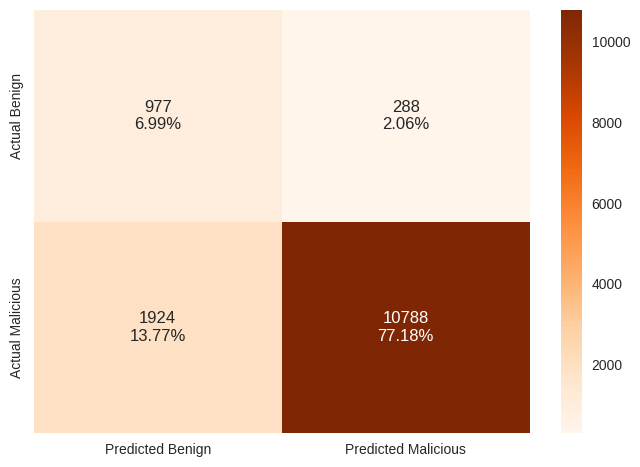

In [ ]:
plot_confusion_matrix(y_val, val_anomaly_preds)

# Conjunto de teste

In [ ]:
test_ocsvm_preds = model_iforest.predict(norm_X_test)

In [ ]:
test_ocsvm_preds[test_ocsvm_preds == 1] = 0
test_ocsvm_preds[test_ocsvm_preds == -1] = 1

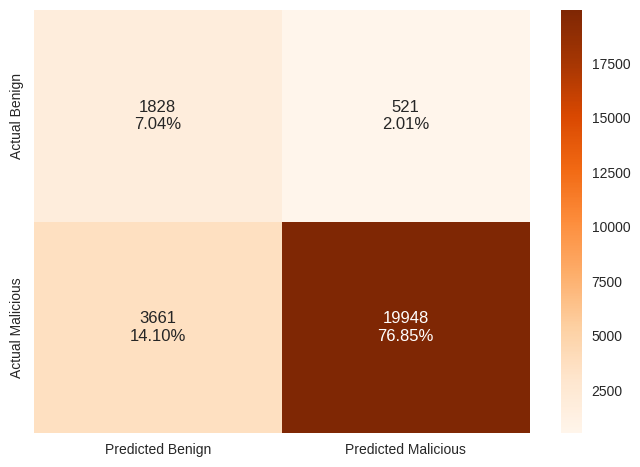

In [ ]:
plot_confusion_matrix(y_test, test_ocsvm_preds)

In [ ]:
import pandas as pd
import numpy as np
import pickle

# === Carrega modelo, scaler e colunas do treino ===
with open("kmeans_model.p", "rb") as f:
    kmeans_model = pickle.load(f)
with open("std_scaler.p", "rb") as f:
    std_scaler = pickle.load(f)
with open("train_cols.p", "rb") as f:
    train_cols = pickle.load(f)

BEST_VALIDATION_THRESHOLD = 0.8623348017621145

# Dados simulados (sem a coluna Label)
data = [
    ["2026-08-11 16:01:35", "can0", "0x131", "00"],
    ["2026-08-11 16:01:35", "can0", "0x141", "00"],
    ["2026-08-11 16:01:35", "can0", "0x36",  "11 11"],
    ["2026-08-11 16:01:35", "can0", "0x141", "00"],
    ["2026-08-11 16:01:35", "can0", "0x26",  "01 10"],
    ["2026-08-11 16:01:35", "can0", "0x131", "00"],
    ["2026-08-11 16:01:40", "can0", "0x26",  "01 10"],
    ["2026-08-11 16:01:40", "can0", "0x131", "00"],
    ["2026-08-11 16:01:40", "can0", "0x36",  "11 11"],
    ["2026-08-11 16:01:40", "can0", "0x141", "00"],
    ["2026-08-11 16:01:40", "can0", "0x141", "00"],
    ["2026-08-11 16:01:40", "can0", "0x36",  "11 11"],
    ["2026-08-11 16:01:40", "can0", "0x26",  "01 10"],
    ["2026-08-11 16:01:40", "can0", "0x131", "00"],
    ["2026-08-11 16:01:40", "can0", "0x26",  "01 10"],
    ["2026-08-11 16:01:45", "can0", "0x131", "00"],
    ["2026-08-11 16:01:45", "can0", "0x36",  "11 11"],
    ["2026-08-11 16:01:45", "can0", "0x141", "00"],
    ["2026-08-11 16:01:45", "can0", "0x141", "00"],
    ["2026-08-11 16:01:45", "can0", "0x26",  "01 10"],
    ["2026-08-11 16:01:45", "can0", "0x36",  "11 11"],
    ["2026-08-11 16:01:45", "can0", "0x131", "00"],
    ["2026-08-11 16:01:45", "can0", "0x36",  "11 11"],
    ["2026-08-11 16:01:45", "can0", "0x26",  "01 10"],
    ["2026-08-11 16:01:50", "can0", "0x131", "00"],
    ["2026-08-11 16:01:50", "can0", "0x141", "00"],
    ["2026-08-11 16:01:50", "can0", "0x141", "00"],
    ["2026-08-11 16:01:50", "can0", "0x26",  "01 10"],
    ["2026-08-11 16:01:50", "can0", "0x36",  "11 11"]
]

df = pd.DataFrame(data, columns=["timestamp", "interface", "can_id", "data"])

# Função de pré-processamento
def preprocess_dataframe(df):
    # Converter timestamp para datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    # Converter can_id para numérico
    df['can_id'] = df['can_id'].apply(
        lambda x: int(x, 16) if isinstance(x, str) and x.startswith('0x') else x
    ).astype(float)
    df['can_id'] = df['can_id'].fillna(0)

    # Calcular diferença de tempo por can_id
    df.sort_values(['can_id', 'timestamp'], inplace=True)
    df['timestamp_diff_ms'] = (
        df.groupby('can_id')['timestamp']
          .diff()
          .dt.total_seconds() * 1000
    ).fillna(0)
    df.sort_index(inplace=True)

    # Dropar timestamp original
    df.drop(columns=['timestamp'], inplace=True)

    # One-hot encode interface
    df = pd.get_dummies(df, columns=['interface'], drop_first=True)

    # Processar coluna data
    data_split = df['data'].str.split(' ', expand=True)
    for col in data_split.columns:
        data_split[col] = data_split[col].apply(
            lambda x: int(x, 16) if isinstance(x, str) else 0
        )
    data_split.columns = [f"data_{i}" for i in range(data_split.shape[1])]

    df = pd.concat([df.drop('data', axis=1), data_split], axis=1)

    # Reindex para colunas do treino
    df = df.reindex(columns=train_cols, fill_value=0)
    return df

# Pré-processar
df_processed = preprocess_dataframe(df)

# Escalar
X_scaled = std_scaler.transform(df_processed)

# Calcular distâncias para os centroides
distances = kmeans_model.transform(X_scaled)
anomaly_scores = np.min(distances, axis=1)

# Classificar
labels = ["Malicious (Anomaly)" if score > BEST_VALIDATION_THRESHOLD else "Benign"
          for score in anomaly_scores]

# Resultado final
result_df = df.copy()
result_df["anomaly_score"] = anomaly_scores
result_df["classification"] = labels

print(result_df)


   interface  can_id   data  timestamp_diff_ms  anomaly_score  \
0       can0   305.0     00                0.0       0.066958   
1       can0   321.0     00                0.0       0.056012   
2       can0    54.0  11 11                0.0       0.090811   
3       can0   321.0     00                0.0       0.056012   
4       can0    38.0  01 1F                0.0       2.657808   
5       can0   305.0     00                0.0       0.066958   
6       can0    38.0  01 10             5000.0       0.760599   
7       can0   305.0     00             5000.0       0.762537   
8       can0    54.0  11 11             5000.0       0.740355   
9       can0   321.0     00             5000.0       0.761654   
10      can0   321.0     00                0.0       0.056012   
11      can0    54.0  11 11                0.0       0.090811   
12      can0    38.0  01 10                0.0       0.049252   
13      can0   305.0     00                0.0       0.066958   
14      can0    38.0  01 

In [ ]:
import pandas as pd
import numpy as np
import pickle

# === Carrega modelo Random Forest, scaler e colunas do treino ===
with open("isolation_forest_model.p", "rb") as f:
    rf_model = pickle.load(f)
with open("std_scaler.p", "rb") as f:
    std_scaler = pickle.load(f)
with open("train_cols.p", "rb") as f:
    train_cols = pickle.load(f)

# Dados simulados (sem a coluna Label)
data = [
    ["2026-08-11 16:01:35", "can0", "0x131", "00"],
    ["2026-08-11 16:01:35", "can0", "0x141", "00"],
    ["2026-08-11 16:01:35", "can0", "0x36",  "11 11"],
    ["2026-08-11 16:01:35", "can0", "0x141", "00"],
    ["2026-08-11 16:01:40", "can0", "0x26",  "FF FF"],
    ["2026-08-11 16:01:40", "can0", "0x131", "00"],
    ["2026-08-11 16:01:40", "can0", "0x26",  "01 10"],
    ["2026-08-11 16:01:40", "can0", "0x131", "00"],
    ["2026-08-11 16:01:40", "can0", "0x36",  "11 11"],
    ["2026-08-11 16:01:40", "can0", "0x141", "00"],
    ["2026-08-11 16:01:40", "can0", "0x141", "00"],
    ["2026-08-11 16:01:40", "can0", "0x36",  "11 11"],
    ["2026-08-11 16:01:40", "can0", "0x26",  "01 10"],
    ["2026-08-11 16:01:40", "can0", "0x131", "00"],
    ["2026-08-11 16:01:45", "can0", "0x26",  "01 10"],
    ["2026-08-11 16:01:45", "can0", "0x131", "00"],
    ["2026-08-11 16:01:45", "can0", "0x36",  "11 11"],
    ["2026-08-11 16:01:45", "can0", "0x141", "00"],
    ["2026-08-11 16:01:45", "can0", "0x141", "00"],
    ["2026-08-11 16:01:45", "can0", "0x26",  "01 10"],
    ["2026-08-11 16:01:45", "can0", "0x36",  "11 11"],
    ["2026-08-11 16:01:35", "can0", "0x131", "00"],
    ["2026-08-11 16:01:35", "can0", "0x36",  "11 11"],
    ["2026-08-11 16:01:35", "can0", "0x26",  "01 10"],
    ["2026-08-11 16:01:35", "can0", "0x131", "00"],
    ["2026-08-11 16:01:35", "can0", "0x141", "00"],
    ["2026-08-11 16:01:35", "can0", "0x141", "00"],
    ["2026-08-11 16:01:35", "can0", "0x26",  "01 10"],
    ["2026-08-11 16:01:35", "can0", "0x36",  "11 11"]
]

df = pd.DataFrame(data, columns=["timestamp", "interface", "can_id", "data"])

# Função de pré-processamento
def preprocess_dataframe(df):
    # Converter timestamp para datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    # Converter can_id para numérico
    df['can_id'] = df['can_id'].apply(
        lambda x: int(x, 16) if isinstance(x, str) and x.startswith('0x') else x
    ).astype(float)
    df['can_id'] = df['can_id'].fillna(0)

    # Calcular diferença de tempo por can_id
    df.sort_values(['can_id', 'timestamp'], inplace=True)
    df['timestamp_diff_ms'] = (
        df.groupby('can_id')['timestamp']
          .diff()
          .dt.total_seconds() * 1000
    ).fillna(0)
    df.sort_index(inplace=True)

    # Dropar timestamp original
    df.drop(columns=['timestamp'], inplace=True)

    # One-hot encode interface
    df = pd.get_dummies(df, columns=['interface'], drop_first=True)

    # Processar coluna data
    data_split = df['data'].str.split(' ', expand=True)
    for col in data_split.columns:
        data_split[col] = data_split[col].apply(
            lambda x: int(x, 16) if isinstance(x, str) else 0
        )
    data_split.columns = [f"data_{i}" for i in range(data_split.shape[1])]

    df = pd.concat([df.drop('data', axis=1), data_split], axis=1)

    # Reindex para colunas do treino
    df = df.reindex(columns=train_cols, fill_value=0)
    return df

# Pré-processar
df_processed = preprocess_dataframe(df)

# Escalar
X_scaled = std_scaler.transform(df_processed)

predictions = rf_model.predict(X_scaled)  # 1 = normal, -1 = anômalo
scores = rf_model.decision_function(X_scaled)  # valores mais negativos = mais anômalo

# Converter para labels legíveis
labels = ["Malicious (Anomaly)" if p == -1 else "Benign" for p in predictions]

# Resultado final
result_df = df.copy()
result_df["anomaly_score"] = scores
result_df["classification"] = labels

print(result_df)

   interface  can_id   data  timestamp_diff_ms  anomaly_score  \
0       can0   305.0     00                0.0       0.117250   
1       can0   321.0     00                0.0       0.126446   
2       can0    54.0  11 11                0.0      -0.148121   
3       can0   321.0     00                0.0       0.126446   
4       can0    38.0  FF FF             5000.0      -0.187043   
5       can0   305.0     00             5000.0      -0.091565   
6       can0    38.0  01 10                0.0       0.001678   
7       can0   305.0     00                0.0       0.117250   
8       can0    54.0  11 11             5000.0      -0.206362   
9       can0   321.0     00             5000.0      -0.077264   
10      can0   321.0     00                0.0       0.126446   
11      can0    54.0  11 11                0.0      -0.148121   
12      can0    38.0  01 10                0.0       0.001678   
13      can0   305.0     00                0.0       0.117250   
14      can0    38.0  01 